In [1]:
#Load Dataset
import pandas as pd

df = pd.read_csv("../data/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [2]:
#EDA + Preprocessing
#Standardize Time and Amount columns
from sklearn.preprocessing import StandardScaler

df['Amount'] = StandardScaler().fit_transform(df[['Amount']])
df['Time'] = StandardScaler().fit_transform(df[['Time']])


In [3]:
#Handle Imbalance
from imblearn.over_sampling import SMOTE

X = df.drop('Class', axis=1)
y = df['Class']

smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)


In [5]:
# Train Model with XGBoost
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# Splitting data into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42)

# Initialize the XGBoost model
model = XGBClassifier(
    n_estimators=50,   # Number of trees (lower for faster training)
    max_depth=5,       # Depth of each tree (lower for faster)
    use_label_encoder=False,  # Avoid warnings about label encoding
    eval_metric='logloss'     # Evaluation metric to optimize
)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Print classification report to evaluate the model
print(classification_report(y_test, y_pred))


c:\Users\shaik\credit-card-fraud-detection\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:08:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56750
           1       1.00      1.00      1.00     56976

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726



              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56750
           1       1.00      1.00      1.00     56976

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726



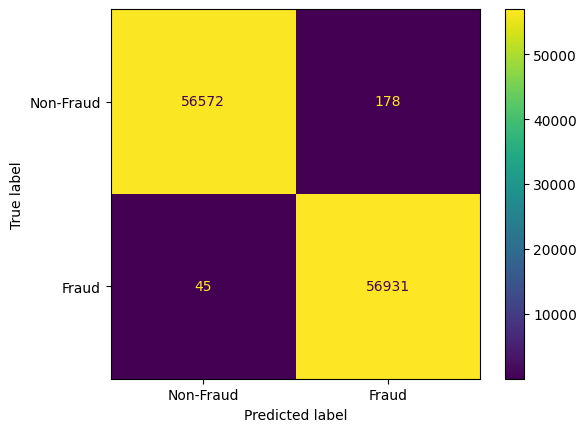

In [7]:
#Evaluate
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Predict the test set results
y_pred = model.predict(X_test)

# Classification Report
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=['Non-Fraud', 'Fraud']).plot()


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56750
           1       1.00      1.00      1.00     56976

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726



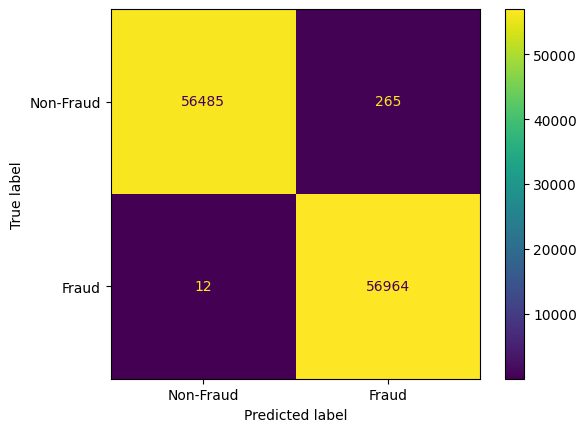

In [8]:
#Threshold Adjustment for Better Detection
from sklearn.metrics import precision_recall_curve

# Get predicted probabilities
y_probs = model.predict_proba(X_test)[:, 1]  # Probabilities for class '1' (fraud)

# Set a custom threshold (for example, 0.4 instead of 0.5)
threshold = 0.4
y_pred_custom = (y_probs >= threshold).astype(int)

# Evaluate with confusion matrix
cm_custom = confusion_matrix(y_test, y_pred_custom)
ConfusionMatrixDisplay(cm_custom, display_labels=['Non-Fraud', 'Fraud']).plot()

# Print classification report with custom threshold
print(classification_report(y_test, y_pred_custom))


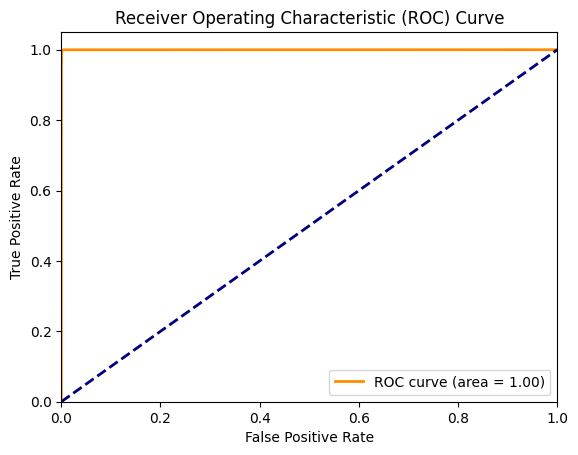

In [9]:
#Visualizing Performance
#a. ROC Curve & AUC Score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
